# Analyzing the metric in various gauges

Load packages

In [1]:
from pybhpt.geo import KerrGeodesic
from pybhpt.radial import RadialTeukolsky
from pybhpt.teuk import TeukolskyMode
from pybhpt.hertz import HertzMode
import numpy as np
import matplotlib.pyplot as plt

Introduce coupling coefficients

In [2]:
from scipy.special import sph_harm
from scipy.special import factorial as fac
from pybhpt.redshift import w3j
import numpy as np

def muCoupling(s, l):
    """
    Eigenvalue for the spin-weighted spherical harmonic lowering operator
    Setting s -> -s gives the negative of the eigenvalue for the raising operator
    """
    if l + s < 0 or l - s + 1. < 0:
        return 0
    return np.sqrt((l - s + 1.)*(l + s))

def Asjlm(s, j, l, m):
    if s >= 0:
        return (-1.)**(m + s)*np.sqrt(4**s*fac(s)**2*(2*l + 1)*(2*j + 1)/fac(2*s))*w3j(s, l, j, 0, m, -m)*w3j(s, l, j, s, -s, 0)
    else:
        return (-1.)**(m)*np.sqrt(4**(-s)*fac(-s)**2*(2*l + 1)*(2*j + 1)/fac(-2*s))*w3j(-s, l, j, 0, m, -m)*w3j(-s, l, j, s, -s, 0)

def spin_operator_normalization(s, ns, l):
    s_sgn = np.sign(s)
    nmax1 = np.abs(s) + 1
    Jterm = 1.
    for ni in range(1, ns + 1):
        Jterm *= -s_sgn*muCoupling((nmax1-ni), l)
    return Jterm

In [83]:
import pickle

class ModeGrid:
    def __init__(self, lmax, ptNum):
        self.maxl = lmax
        self.modeCount = 0
        self.lmodes = []
        self.mmodes = []
        for l in range(0, self.maxl + 1):
            for m in range(-l, l + 1):
                self.lmodes.append(l)
                self.mmodes.append(m)
        
        self.lmodes = np.array(self.lmodes)
        self.mmodes = np.array(self.mmodes)
        self.modes = np.zeros((self.lmodes.shape[0], ptNum), dtype=np.complex128)

    def pos(self, l, m):
        pos = np.where(np.logical_and(self.lmodes == l, self.mmodes == m))
        if len(pos) == 1:
            return pos[0]
        else:
            return pos

    def set(self, l, m, val):
        self.modes[self.pos(l, m)] = val

    def add(self, l, m, val):
        self.modes[self.pos(l, m)] += val
    
    def get(self, l, m):
        return self.modes[self.pos(l, m)]

    def __call__(self, l, m):
        return self.get(l, m)

class HertzCircularGrid:
    def __init__(self, orbit, gauge, rpts, lmax):
        self.maxl = lmax
        self.geo = orbit
        self.r0 = self.geo.semilatusrectum
        self.gauge = gauge
        self.inner = rpts[rpts <= self.r0]
        self.outer = rpts[rpts >= self.r0]
        self.pts = np.concatenate((self.inner, self.outer))
        self.psi = ModeGrid(lmax, self.pts.shape[0])
        self.dpsi = ModeGrid(lmax, self.pts.shape[0])
        self.ddpsi = ModeGrid(lmax, self.pts.shape[0])
        self.lmodes = np.arange(2, lmax + 1)
        self.mmodes = np.arange(-lmax, lmax + 1)
        self.filename = ".hertz_grid_a0_" + str(self.geo.blackholespin) + "_r0_" + str(self.r0) + "_gauge_" + str(self.gauge) + "_ptsNum_" + str(self.pts.shape[0]) + "_modeNum_" + str(self.lmodes.shape[0])

    # def sanity_check(self, RInner, ROuter, hertz):
    #     r0UpIter = 0
    #     r0InIter = self.inner.shape[0] - 1
    #     Rup = ROuter.solution('Up', r0UpIter)
    #     Rin = RInner.solution('In', r0InIter)
    #     assert (np.abs(1. - Rin/hertz.homogeneousradialsolution('In', 0)) < 1.e-8), "Horizon-side Hertz field values of {} and {} do not match for mode {}".format(Rin, hertz.homogeneousradialsolution('In', 0), (RInner.spinweight, RInner.spheroidalmode, RInner.azimuthalmode, RInner.frequency))
    #     assert (np.abs(1. - Rup/hertz.homogeneousradialsolution('Up', 0)) < 1.e-8), "Infinity-side Hertz field values of {} and {} do not match for mode {}".format(Rup, hertz.homogeneousradialsolution('Up', 0),  (ROuter.spinweight, ROuter.spheroidalmode, ROuter.azimuthalmode, ROuter.frequency))

    def solve(self):
        if self.gauge in ["IRG", "ASAAB0", "SAAB0"]:
            s = -2
        else:
            s = 2
        for m in self.mmodes:
            lmin = np.max([2, abs(m)])
            jmodes = np.arange(lmin, self.maxl + 31)
            for j in jmodes:
                teuk = TeukolskyMode(s, j, m, 0, 0, self.geo)
                teuk.solve(self.geo)
                hertz = HertzMode(teuk, self.gauge)
                hertz.solve()
                PsiUpJ = hertz.amplitude('Up')
                PsiInJ = hertz.amplitude('In')
                if self.outer.shape[0] > 0:
                    ROuter = RadialTeukolsky(s, j, m, teuk.blackholespin, teuk.frequency, self.outer)
                    ROuter.solve(bc='Up')
                    Rup = np.array([ROuter.radialsolution('Up', i) for i in range(self.outer.shape[0])])
                    dRup = np.array([ROuter.radialderivative('Up', i) for i in range(self.outer.shape[0])])
                    ddRup = np.array([ROuter.radialderivative2('Up', i) for i in range(self.outer.shape[0])])
                else:
                    Rup = np.array([])
                    dRup = np.array([])
                    ddRup = np.array([])
                if self.inner.shape[0] > 0:  
                    RInner = RadialTeukolsky(s, j, m, teuk.blackholespin, teuk.frequency, self.inner)
                    RInner.solve(bc='In')
                    Rin = np.array([RInner.radialsolution('In', i) for i in range(self.inner.shape[0])])
                    dRin = np.array([RInner.radialderivative('In', i) for i in range(self.inner.shape[0])])
                    ddRin = np.array([RInner.radialderivative2('In', i) for i in range(self.inner.shape[0])])
                else:
                    Rin = np.array([])
                    dRin = np.array([])
                    ddRin = np.array([])

                for l in range(abs(m), self.maxl + 1):
                    PsiIn = hertz.couplingcoefficient(l)*PsiInJ
                    PsiUp = hertz.couplingcoefficient(l)*PsiUpJ
                    Psi = np.concatenate((PsiIn*Rin, PsiUp*Rup)) 
                    dPsi = np.concatenate((PsiIn*dRin, PsiUp*dRup)) 
                    ddPsi = np.concatenate((PsiIn*ddRin, PsiUp*ddRup)) 
                    self.psi.add(l, m, Psi)
                    self.dpsi.add(l, m, dPsi)
                    self.ddpsi.add(l, m, ddPsi)

    def set(self, l, m, val0, val1, val2):
        self.psi.set(l, m, val0)
        self.dpsi.set(l, m, val1)
        self.ddpsi.set(l, m, val2)

    def save(self, fn = None):
        if fn is None:
            fn = self.filename + ".pkl"
        with open(fn, 'wb') as outp:
            pickle.dump([self.psi, self.dpsi, self.ddpsi], outp, pickle.HIGHEST_PROTOCOL)

    def load(self, fn = None):
        if fn is None:
            fn = self.filename + ".pkl"
        with open(fn, 'rb') as inp:
            tmp_array = pickle.load(inp)
            self.psi, self.dpsi, self.ddpsi = tmp_array
        
    def __call__(self, l, m, deriv=0):
        if deriv == 0:
            return self.psi(l, m)
        elif deriv == 1:
            return self.dpsi(l, m)
        elif deriv == 2:
            return self.ddpsi(l, m)
        else:
            return self.psi(l, m)

In [84]:
from pybhpt.redshift import metric_coefficients_IRG, metric_coefficients_ORG
from pybhpt.redshift import Yslm

def habcoeffs_IRG(a, b, c, d, q, rvals, zvals):
    h22 = np.array([[metric_coefficients_IRG(2, 2, a, b, c, d, q, r, z) for r in rvals] for z in zvals])
    h24 = np.array([[metric_coefficients_IRG(2, 4, a, b, c, d, q, r, z) for r in rvals] for z in zvals])
    h44 = np.array([[metric_coefficients_IRG(4, 4, a, b, c, d, q, r, z) for r in rvals] for z in zvals])
    return np.array([2.*h22.real, h24, h44])

def habcoeffs_ORG(a, b, c, d, q, rvals, zvals):
    h11 = np.array([[metric_coefficients_ORG(1, 1, a, b, c, d, q, r, z) for r in rvals] for z in zvals])
    h13 = np.array([[metric_coefficients_ORG(1, 3, a, b, c, d, q, r, z) for r in rvals] for z in zvals])
    h33 = np.array([[metric_coefficients_ORG(3, 3, a, b, c, d, q, r, z) for r in rvals] for z in zvals])
    return np.array([2.*h11.real, h13, h33])

def habcoeffs(gauge, a, b, c, d, q, rvals, zvals):
    if gauge in ["IRG", "ASAAB0", "SAAB0"]:
        return habcoeffs_IRG(a, b, c, d, q, rvals, zvals)
    else:
        return habcoeffs_ORG(a, b, c, d, q, rvals, zvals)

from tqdm import tqdm

def hab_mode_calc(l, m, hertzMode):
    rvals = hertzMode.pts
    zvals = [0.]
    q = hertzMode.geo.blackholespin
    omega = hertzMode.geo.mode_frequency(m, 0, 0)
    gauge = hertzMode.gauge
    s_sgn = 1
    if gauge in ["IRG", "ASAAB0", "SAAB0"]:
        s_sgn = -1
    hab = np.zeros((3, rvals.shape[0]), dtype=np.complex128)
    for ns in range(0, 3):
        Jterm = spin_operator_normalization(s_sgn*2, ns, l)
        yslm = Jterm*np.real(Yslm(s_sgn*(2-ns), l, m, 0.5*np.pi))
        for nt in range(0, 3):
            for nph in range(0, 3):
                pref = (1.j*m)**nph*(-1.j*omega)**nt
                for nr in range(0, 3):
                    if nt + nr + ns + nph <= 2:
                        hNabcds = habcoeffs(gauge, nt, nr, ns, nph, q, rvals, zvals)
                        huuTerm = []
                        for hNabcd in hNabcds:
                            huuTerm.append(-pref*hNabcd[0]*yslm*hertzMode(l, m, deriv=nr)[0])
                        hab += np.array(huuTerm)
    return hab

In [85]:
geo = KerrGeodesic(0.5, 10., 0., 1.0, 2**2)
rplus = 1. + np.sqrt(1. - geo.blackholespin**2)
lmax = 20
rInner = np.logspace(np.log10(rplus*(1. + 1.e-7)), np.log10(10), 2000)
rUpper = 1/np.logspace(np.log10(1/10.), np.log10(1/3000), 2000)
r2=np.concatenate((rInner, rUpper))
print("Solve IRG")
hertz0=HertzCircularGrid(geo, "IRG", r2, lmax)
hertz0.solve()
print("Solve ORG")
hertz4=HertzCircularGrid(geo, "ORG", r2, lmax)
hertz4.solve()
print("Solve AAB")
hertzAAB0=HertzCircularGrid(geo, "SAAB0", r2, lmax)
hertzAAB0.solve()
hertzAAB4=HertzCircularGrid(geo, "SAAB4", r2, lmax)
hertzAAB4.solve()

Solve IRG
Solve ORG
Solve AAB


In [86]:
def hab_l_mode(l, hertz):
    habl = np.zeros((3, hertz.pts.shape[0]), dtype=np.complex128)
    for m in range(-l, l + 1):
        habl += hab_mode_calc(l, m, hertz)
    return habl

def hab_sum(lmax, hertz):
    hab = np.zeros((3, hertz.pts.shape[0]), dtype=np.complex128)
    for l in range(2, lmax + 1):
        for m in range(-l, l + 1):
            hab += hab_mode_calc(l, m, hertz)
    return hab

def hertz_l_mode(l, hertz):
    gauge = hertz.gauge
    s = 2
    if gauge in ["IRG", "ASAAB0", "SAAB0"]:
        s = -2
    psil = np.zeros((hertz.pts.shape[0]), dtype=np.complex128)
    for m in range(-l, l + 1):
        psil += hertz(l, m)[0]*Yslm(s, l, m, 0.5*np.pi)
    return psil

In [87]:
test0 = hab_sum(20, hertz0)
test4 = hab_sum(20, hertz4)
testAAB0 = hab_sum(20, hertzAAB0)
testAAB4 = hab_sum(20, hertzAAB4)

In [88]:
# plt.plot(1/hertz0.pts, np.abs(test0[0]))
# plt.plot(1/hertz0.pts, np.abs(test0[1]))
# plt.plot(1/hertz0.pts, np.abs(test0[2]))
# plt.yscale('log')
# plt.show()

In [89]:
# plt.plot(1/hertz4.pts, np.abs(test4[0]))
# plt.plot(1/hertz4.pts, np.abs(test4[1]))
# plt.plot(1/hertz4.pts, np.abs(test4[2]))
# plt.yscale('log')
# plt.show()

In [90]:
def tetrad_project_l(a, r, z, mu):
    if mu == 0:
        return -1
    elif mu == 1:
        sigma = r**2 + a**2*z**2
        delta = r**2 - 2.*r + a**2
        return sigma/delta
    elif mu == 2:
        return 0.
    elif mu == 3:
        return a*(1. - z**2)
    else:
        return 0.
    
def tetrad_project_n(a, r, z, mu):
    sigma = r**2 + a**2*z**2
    delta = r**2 - 2.*r + a**2
    if mu == 0:
        return -0.5*delta/sigma
    elif mu == 1:
        return -0.5
    elif mu == 2:
        return 0.
    elif mu == 3:
        return 0.5*delta/sigma*a*(1. - z**2)
    else:
        return 0.
    
def tetrad_project_m(a, r, z, mu):
    rhobar = -1./(r + 1j*a*z)
    sigma = r**2 + a**2*z**2
    pref = - rhobar*np.sqrt(0.5*(1. - z**2))
    if mu == 0:
        return -1j*pref*a
    elif mu == 1:
        return 0.
    elif mu == 2:
        return -pref*sigma/(1. - z**2)
    elif mu == 3:
        return 1j*pref*(r**2 + a**2)
    else:
        return 0.
    
def tetrad_projection(b, q, r, z, mu):
    if b == 1:
        return tetrad_project_l(q, r, z, mu)
    elif b == 2:
        return tetrad_project_n(q, r, z, mu)
    elif b == 3:
        return tetrad_project_m(q, r, z, mu)
    elif b == 4:
        return np.conj(tetrad_project_m(q, r, z, mu))
    else:
        return 0.

In [91]:
def htt(gauge, q, r, hab):
    if gauge in ["IRG", "ASAAB0", "SAAB0"]:
        lt = tetrad_projection(1, q, r, 0, 0)
        mt = tetrad_projection(3, q, r, 0, 0)
        h22 = lt**2*hab[0]
        h24 = -2.*lt*mt*hab[1]
        h44 = mt**2*hab[2]
        return -(h22.real + 2.*h24.real + 2.*h44.real)
    else:
        nt = tetrad_projection(2, q, r, 0, 0)
        mbt = tetrad_projection(4, q, r, 0, 0)
        h11 = nt**2*hab[0]
        h13 = -2.*nt*mbt*hab[1]
        h33 = mbt**2*hab[2]
        return -(h11.reak + 2.*h13.real + 2.*h33.real)

In [92]:
def hmunu(gauge, mu, nu, q, r, hab):
    if gauge in ["IRG", "ASAAB0", "SAAB0"]:
        e1mu = tetrad_projection(1, q, r, 0, mu)
        e1nu = tetrad_projection(1, q, r, 0, nu)
        e3mu = tetrad_projection(3, q, r, 0, mu)
        e3nu = tetrad_projection(3, q, r, 0, nu)
        h22 = e1mu*e1nu*hab[0]
        h24 = -e1mu*e3nu*hab[1] - e1nu*e3mu*hab[1]
        h44 = e3mu*e3nu*hab[2]
        return -(h22.real + 2.*h24.real + 2.*h44.real)
    else:
        e1mu = tetrad_projection(2, q, r, 0, mu)
        e1nu = tetrad_projection(2, q, r, 0, nu)
        e3mu = tetrad_projection(4, q, r, 0, mu)
        e3nu = tetrad_projection(4, q, r, 0, nu)
        h11 = e1mu*e1nu*hab[0]
        h13 = -e1mu*e3nu*hab[1] - e1nu*e3mu*hab[1]
        h33 = e3mu*e3nu*hab[2]
        return -(h11.real + 2.*h13.real + 2.*h33.real)

In [93]:
httIRG = hmunu("IRG", 0, 0, hertz0.geo.blackholespin, hertz0.pts, test0)
httORG = hmunu("ORG", 0, 0, hertz4.geo.blackholespin, hertz4.pts, test4)
httAAB = 0.5*(hmunu("SAAB0", 0, 0, hertzAAB0.geo.blackholespin, hertzAAB0.pts, testAAB0) + hmunu("SAAB4", 0, 0, hertzAAB4.geo.blackholespin, hertzAAB4.pts, testAAB4))

In [94]:
def sig_of_r(q, r):
    kappa = np.sqrt(1. - q**2)
    sig = 2.*kappa/(r - 1. + kappa)
    return sig

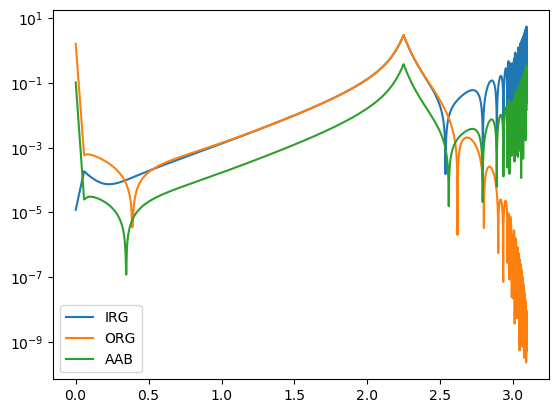

In [95]:
sigX = np.arccos(2*rplus/hertz0.pts - 1)
plt.plot(sigX, np.abs(httIRG), label = "IRG")
plt.plot(sigX, np.abs(httORG), label = "ORG")
plt.plot(sigX, np.abs(httAAB), label = "AAB")
plt.yscale('log')
plt.legend()
plt.show()

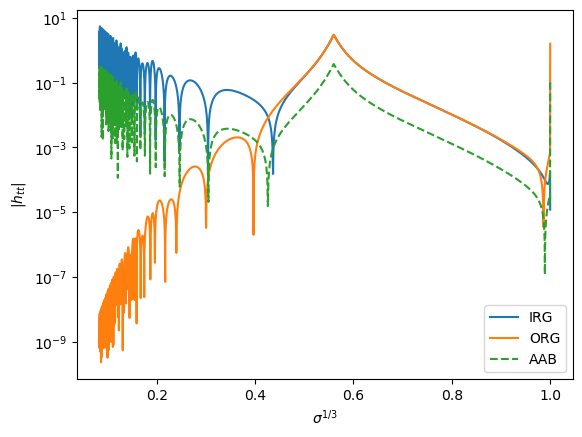

In [96]:
sigX = sig_of_r(geo.blackholespin, hertz0.pts)**(1/3)
plt.plot(sigX, np.abs(httIRG), label = "IRG")
plt.plot(sigX, np.abs(httORG), label = "ORG")
plt.plot(sigX, np.abs(httAAB), '--', label = "AAB")
plt.yscale('log')
plt.xlabel('$\sigma^{1/3}$')
plt.ylabel('$|h_{tt}|$')
plt.legend()
plt.show()